In [10]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm


base_input_dir = '/Users/unar/Downloads/Data'
processed_output_dir = '/Users/unar/Downloads/ct_scan_1_processed_45'

splits = ['train', 'valid', 'test']
classes = ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']


def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


for split in splits:
    for cls in classes:
        input_dir = os.path.join(base_input_dir, split, cls)
        output_dir = os.path.join(processed_output_dir, split, cls)
        os.makedirs(output_dir, exist_ok=True)

        if not os.path.exists(input_dir):
            print(f"[Warning] {input_dir} does not exist!")
            continue

        
        valid_exts = ['.jpg', '.jpeg', '.png']
        image_files = [p for p in Path(input_dir).rglob('*') if p.suffix.lower() in valid_exts]

        skipped = 0
        for img_path in tqdm(image_files, desc=f'Processing {split}/{cls}'):
            try:
                img = cv2.imread(str(img_path))
                if img is None:
                    skipped += 1
                    continue

                img = apply_median_filter(img)
                img = apply_histogram_equalization(img)
                img = apply_clahe(img)
                img = apply_morphological_ops(img)

                save_path = os.path.join(output_dir, os.path.basename(img_path))
                success = cv2.imwrite(save_path, img)
                if not success:
                    skipped += 1

            except Exception as e:
                skipped += 1
                print(f"[Error] {img_path}: {e}")

        print(f"[{split}/{cls}] Skipped {skipped} images.")

Processing train/normal: 100%|████████████████| 148/148 [00:01<00:00, 93.99it/s]


[train/normal] Skipped 0 images.


Processing train/adenocarcinoma: 100%|███████| 195/195 [00:00<00:00, 211.12it/s]


[train/adenocarcinoma] Skipped 0 images.


Processing train/large.cell.carcinoma: 100%|█| 115/115 [00:00<00:00, 227.05it/s]


[train/large.cell.carcinoma] Skipped 0 images.


Processing train/squamous.cell.carcinoma: 100%|█| 155/155 [00:00<00:00, 218.75it


[train/squamous.cell.carcinoma] Skipped 0 images.


Processing valid/normal: 100%|██████████████████| 13/13 [00:00<00:00, 75.00it/s]


[valid/normal] Skipped 0 images.


Processing valid/adenocarcinoma: 100%|█████████| 23/23 [00:00<00:00, 253.20it/s]


[valid/adenocarcinoma] Skipped 0 images.


Processing valid/large.cell.carcinoma: 100%|███| 21/21 [00:00<00:00, 247.83it/s]


[valid/large.cell.carcinoma] Skipped 0 images.


Processing valid/squamous.cell.carcinoma: 100%|█| 15/15 [00:00<00:00, 226.83it/s


[valid/squamous.cell.carcinoma] Skipped 0 images.


Processing test/normal: 100%|███████████████████| 54/54 [00:00<00:00, 84.24it/s]


[test/normal] Skipped 0 images.


Processing test/adenocarcinoma: 100%|████████| 120/120 [00:00<00:00, 181.50it/s]


[test/adenocarcinoma] Skipped 0 images.


Processing test/large.cell.carcinoma: 100%|████| 51/51 [00:00<00:00, 197.62it/s]


[test/large.cell.carcinoma] Skipped 0 images.


Processing test/squamous.cell.carcinoma: 100%|█| 90/90 [00:00<00:00, 183.97it/s]

[test/squamous.cell.carcinoma] Skipped 0 images.


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


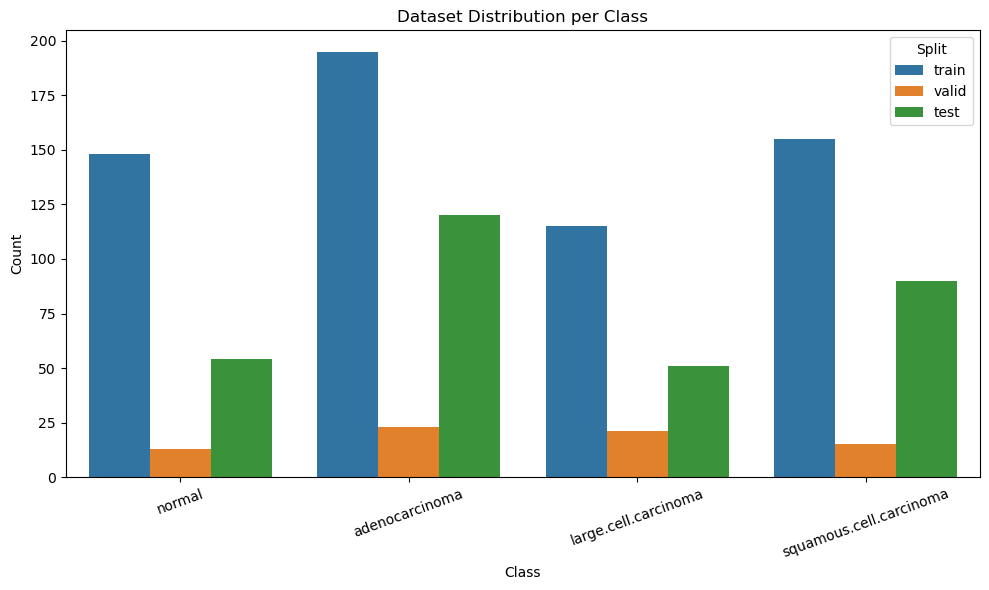

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

base_input_dir = '/Users/unar/Downloads/ct_scan_1_processed_45'

splits = ['train', 'valid', 'test']
classes = ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

data_counts = defaultdict(dict)

for split in splits:
    for cls in classes:
        dir_path = os.path.join(base_input_dir, split, cls)
        if not os.path.exists(dir_path):
            data_counts[split][cls] = 0
            continue
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        data_counts[split][cls] = count


plot_data = []
for split in splits:
    for cls in classes:
        plot_data.append({'Split': split, 'Class': cls, 'Count': data_counts[split][cls]})

import pandas as pd
df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Class', y='Count', hue='Split')
plt.title('Dataset Distribution per Class')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

checkpoint = ModelCheckpoint("mobilenetv2_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("\n Training top layers of MobileNetV2...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\n Fine-tuning MobileNetV2 base model...")
base_model.trainable = True

for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

print("\n Evaluating MobileNetV2 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f" Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of MobileNetV2...
Epoch 1/150


2025-04-17 23:57:45.635050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.8353 - accuracy: 0.3980 - precision: 0.4063 - recall: 0.3785

2025-04-17 23:57:50.773214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to mobilenetv2_ct_scan_best.h5
20/20 [==============================] - 7s 299ms/step - loss: 2.8353 - accuracy: 0.3980 - precision: 0.4063 - recall: 0.3785 - val_loss: 1.3643 - val_accuracy: 0.4583 - val_precision: 0.5082 - val_recall: 0.4306
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.1303 - accuracy: 0.5220 - precision: 0.5371 - recall: 0.5073
Epoch 2: val_accuracy improved from 0.45833 to 0.55556, saving model to mobilenetv2_ct_scan_best.h5
20/20 [==============================] - 5s 247ms/step - loss: 2.1303 - accuracy: 0.5220 - precision: 0.5371 - recall: 0.5073 - val_loss: 1.2121 - val_accuracy: 0.5556 - val_precision: 0.5606 - val_recall: 0.5139
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.6066 - accuracy: 0.5432 - precision: 0.5571 - recall: 0.5253
Epoch 3: val_accuracy did not improve from 0.55556
20/20 [==============================] - 5s 243ms/step - loss


🔧 Fine-tuning MobileNetV2 base model...
Epoch 1/150


2025-04-18 00:04:54.088610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 4.1519 - accuracy: 0.3752 - precision: 0.3737 - recall: 0.3573

2025-04-18 00:05:02.551593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.79167
20/20 [==============================] - 11s 386ms/step - loss: 4.1519 - accuracy: 0.3752 - precision: 0.3737 - recall: 0.3573 - val_loss: 0.7391 - val_accuracy: 0.7917 - val_precision: 0.7941 - val_recall: 0.7500
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.8727 - accuracy: 0.4454 - precision: 0.4609 - recall: 0.4323
Epoch 2: val_accuracy did not improve from 0.79167
20/20 [==============================] - 6s 302ms/step - loss: 2.8727 - accuracy: 0.4454 - precision: 0.4609 - recall: 0.4323 - val_loss: 0.7719 - val_accuracy: 0.7917 - val_precision: 0.7971 - val_recall: 0.7639
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.8870 - accuracy: 0.5514 - precision: 0.5557 - recall: 0.5204
Epoch 3: val_accuracy did not improve from 0.79167
20/20 [==============================] - 6s 306ms/step - loss: 1.8870 - accuracy: 0.5514 - precision: 0.5557 - recall: 0.5204 - val_loss: 0.7949 - val_accu

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall



base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


checkpoint = ModelCheckpoint("densenet121_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("\n Training top layers of DenseNet121...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\nFine-tuning DenseNet121 base model...")
base_model.trainable = True


for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\n Evaluating DenseNet121 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f" Test Precision: {precision * 100:.2f}%")
print(f" Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of DenseNet121...
Epoch 1/150


2025-04-18 00:08:41.474246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.4559 - accuracy: 0.3458 - precision: 0.3606 - recall: 0.3165

2025-04-18 00:08:49.619655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.36111, saving model to densenet121_ct_scan_best.h5
20/20 [==============================] - 13s 485ms/step - loss: 2.4559 - accuracy: 0.3458 - precision: 0.3606 - recall: 0.3165 - val_loss: 1.4853 - val_accuracy: 0.3611 - val_precision: 0.4000 - val_recall: 0.3056
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.6844 - accuracy: 0.4535 - precision: 0.4685 - recall: 0.4127
Epoch 2: val_accuracy improved from 0.36111 to 0.51389, saving model to densenet121_ct_scan_best.h5
20/20 [==============================] - 6s 310ms/step - loss: 1.6844 - accuracy: 0.4535 - precision: 0.4685 - recall: 0.4127 - val_loss: 1.5335 - val_accuracy: 0.5139 - val_precision: 0.5294 - val_recall: 0.5000
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.3635 - accuracy: 0.5139 - precision: 0.5276 - recall: 0.4682
Epoch 3: val_accuracy did not improve from 0.51389
20/20 [==============================] - 7s 325ms/step - los


🔧 Fine-tuning DenseNet121 base model...
Epoch 1/150


2025-04-18 00:13:59.331454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 4.0151 - accuracy: 0.3622 - precision: 0.3667 - recall: 0.3589

2025-04-18 00:14:26.952626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.73611
20/20 [==============================] - 36s 1s/step - loss: 4.0151 - accuracy: 0.3622 - precision: 0.3667 - recall: 0.3589 - val_loss: 0.7615 - val_accuracy: 0.6944 - val_precision: 0.7231 - val_recall: 0.6528
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.7605 - accuracy: 0.3964 - precision: 0.4084 - recall: 0.3817
Epoch 2: val_accuracy did not improve from 0.73611
20/20 [==============================] - 22s 1s/step - loss: 2.7605 - accuracy: 0.3964 - precision: 0.4084 - recall: 0.3817 - val_loss: 0.8180 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.5833
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.9829 - accuracy: 0.4796 - precision: 0.4884 - recall: 0.4454
Epoch 3: val_accuracy did not improve from 0.73611
20/20 [==============================] - 22s 1s/step - loss: 1.9829 - accuracy: 0.4796 - precision: 0.4884 - recall: 0.4454 - val_loss: 0.8432 - val_accuracy: 0

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall



base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


checkpoint = ModelCheckpoint("resnet50_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


print("\n Training top layers of ResNet50...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\n Fine-tuning ResNet50 base model...")
base_model.trainable = True

for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

print("\n Evaluating ResNet50 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of ResNet50...
Epoch 1/150


2025-04-18 02:28:17.431062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.7788 - accuracy: 0.3034 - precision: 0.3203 - recall: 0.1876

2025-04-18 02:28:23.900571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.47222, saving model to resnet50_ct_scan_best.h5
20/20 [==============================] - 12s 376ms/step - loss: 1.7788 - accuracy: 0.3034 - precision: 0.3203 - recall: 0.1876 - val_loss: 1.3230 - val_accuracy: 0.4722 - val_precision: 0.4516 - val_recall: 0.1944
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.5686 - accuracy: 0.3801 - precision: 0.4278 - recall: 0.2512
Epoch 2: val_accuracy did not improve from 0.47222
20/20 [==============================] - 6s 284ms/step - loss: 1.5686 - accuracy: 0.3801 - precision: 0.4278 - recall: 0.2512 - val_loss: 1.4652 - val_accuracy: 0.4028 - val_precision: 0.6667 - val_recall: 0.2222
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.3328 - precision: 0.3507 - recall: 0.1974
Epoch 3: val_accuracy did not improve from 0.47222
20/20 [==============================] - 6s 302ms/step - loss: 1.5601 - accuracy: 0.3328 - precision: 0.3507 - r


🔧 Fine-tuning ResNet50 base model...
Epoch 1/150


2025-04-18 02:32:08.653994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 21.0768 - accuracy: 0.2414 - precision: 0.2414 - recall: 0.2414

2025-04-18 02:32:26.921663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.51389
20/20 [==============================] - 24s 1s/step - loss: 21.0768 - accuracy: 0.2414 - precision: 0.2414 - recall: 0.2414 - val_loss: 2.5690 - val_accuracy: 0.1806 - val_precision: 0.1806 - val_recall: 0.1806
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 9.2579 - accuracy: 0.2545 - precision: 0.2512 - recall: 0.2463
Epoch 2: val_accuracy did not improve from 0.51389
20/20 [==============================] - 17s 834ms/step - loss: 9.2579 - accuracy: 0.2545 - precision: 0.2512 - recall: 0.2463 - val_loss: 9.5928 - val_accuracy: 0.1806 - val_precision: 0.1806 - val_recall: 0.1806
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 2.4422 - accuracy: 0.3687 - precision: 0.3758 - recall: 0.3034
Epoch 3: val_accuracy did not improve from 0.51389
20/20 [==============================] - 16s 786ms/step - loss: 2.4422 - accuracy: 0.3687 - precision: 0.3758 - recall: 0.3034 - val_loss: 17.7303 - val_acc

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


checkpoint = ModelCheckpoint("vgg19_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


print("\nTraining top layers of VGG19...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\nFine-tuning VGG19 base model...")
base_model.trainable = True


for layer in base_model.layers[:10]:
    layer.trainable = False


model.compile(
    optimizer=Adam(1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)


print("\nEvaluating on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\n Test Accuracy: {accuracy * 100:.2f}%")
print(f" Test Precision: {precision * 100:.2f}%")
print(f" Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of VGG19...
Epoch 1/150


2025-04-18 21:51:11.287023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.5272 - accuracy: 0.3002 - precision: 0.3240 - recall: 0.0946

2025-04-18 21:51:19.189441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.40278, saving model to vgg19_ct_scan_best.h5


/Users/unar/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 9s 433ms/step - loss: 1.5272 - accuracy: 0.3002 - precision: 0.3240 - recall: 0.0946 - val_loss: 1.3621 - val_accuracy: 0.4028 - val_precision: 1.0000 - val_recall: 0.0278
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.2984 - accuracy: 0.3752 - precision: 0.6033 - recall: 0.1191
Epoch 2: val_accuracy did not improve from 0.40278
20/20 [==============================] - 9s 428ms/step - loss: 1.2984 - accuracy: 0.3752 - precision: 0.6033 - recall: 0.1191 - val_loss: 1.2621 - val_accuracy: 0.3889 - val_precision: 0.9286 - val_recall: 0.1806
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.2150 - accuracy: 0.4274 - precision: 0.5776 - recall: 0.1517
Epoch 3: val_accuracy improved from 0.40278 to 0.41667, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 10s 500ms/step - loss: 1.2150 - accuracy: 0.4274 - precision: 0.5776 - recall: 0.1517 - val_loss: 1.2107 - val_accuracy: 0.4


🔧 Fine-tuning VGG19 base model...
Epoch 1/150


2025-04-18 22:29:23.535477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7357 - precision: 0.7491 - recall: 0.7113

2025-04-18 22:30:02.181152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.77778
20/20 [==============================] - 41s 2s/step - loss: 0.7135 - accuracy: 0.7357 - precision: 0.7491 - recall: 0.7113 - val_loss: 0.5714 - val_accuracy: 0.7639 - val_precision: 0.7536 - val_recall: 0.7222
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8059 - precision: 0.8204 - recall: 0.7749
Epoch 2: val_accuracy improved from 0.77778 to 0.80556, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 37s 2s/step - loss: 0.4905 - accuracy: 0.8059 - precision: 0.8204 - recall: 0.7749 - val_loss: 0.4643 - val_accuracy: 0.8056 - val_precision: 0.8636 - val_recall: 0.7917
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8483 - precision: 0.8752 - recall: 0.8238
Epoch 3: val_accuracy improved from 0.80556 to 0.81944, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 39s 2s/step - loss: 0.3939 - accu

In [6]:
from tensorflow.keras.models import load_model

model_VGG = load_model('vgg19_ct_scan_best.h5')


2025-04-18 23:43:40.169910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 618ms/step


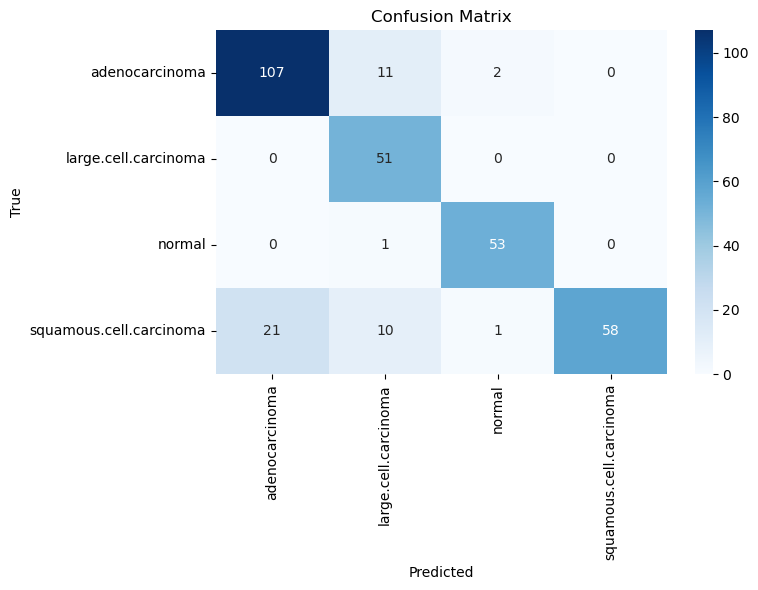


📋 Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.84      0.89      0.86       120
   large.cell.carcinoma       0.70      1.00      0.82        51
                 normal       0.95      0.98      0.96        54
squamous.cell.carcinoma       1.00      0.64      0.78        90

               accuracy                           0.85       315
              macro avg       0.87      0.88      0.86       315
           weighted avg       0.88      0.85      0.85       315



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_gen.reset()
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

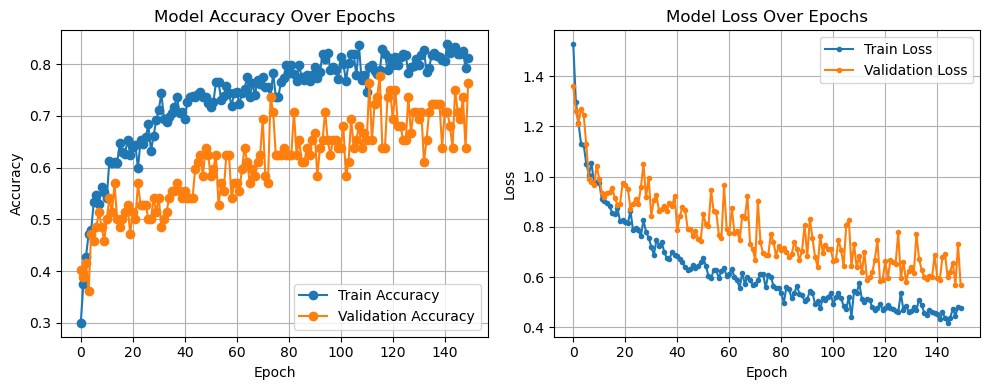

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='.')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='.')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

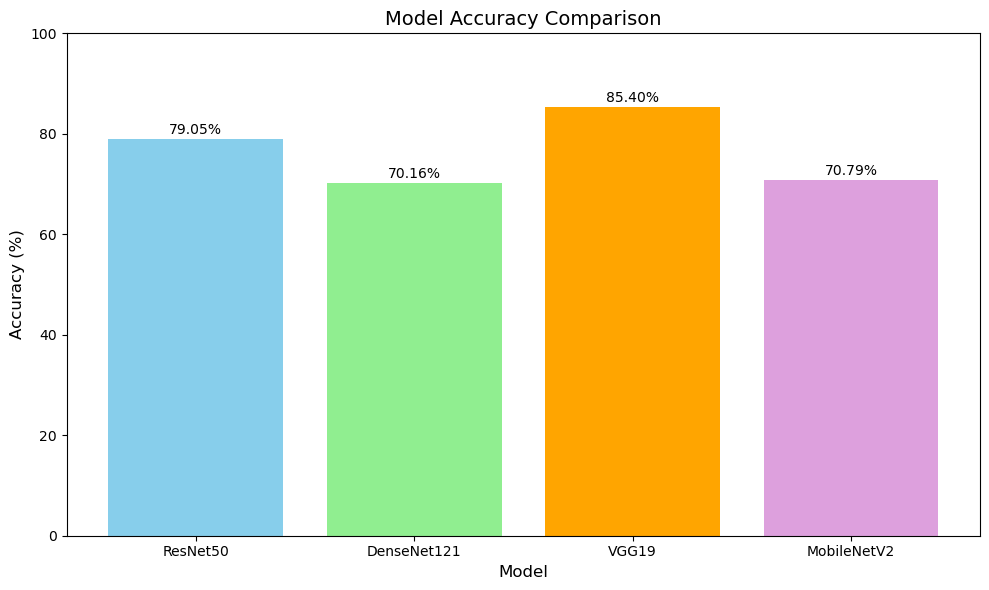

In [12]:
import matplotlib.pyplot as plt

model_names = ['ResNet50', 'DenseNet121', 'VGG19', 'MobileNetV2']
accuracies = [79.05, 70.16, 85.40, 70.79]  

plt.figure(figsize=(10, 6))  
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange', 'plum'])


plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylim(0, 100)  
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=10)


plt.tight_layout() 
plt.show()

2025-04-17 22:56:40.494842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 492ms/step


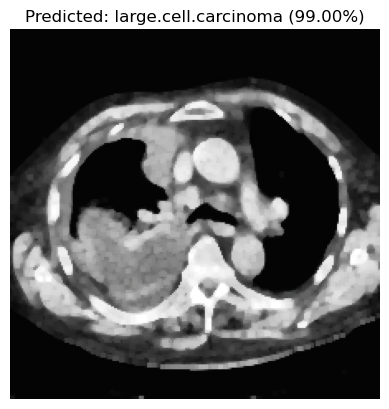

In [3]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2


def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

img_path = '/Users/unar/Downloads/LLDS.png'  
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) 


processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)


processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]


plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 16ms/step


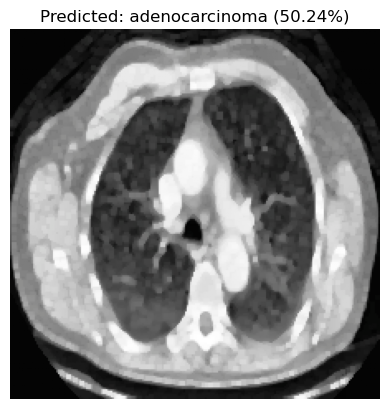

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2


def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


img_path = '/Users/unar/Downloads/AD.png' 
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)


processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)


processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)


prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]


plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 13ms/step


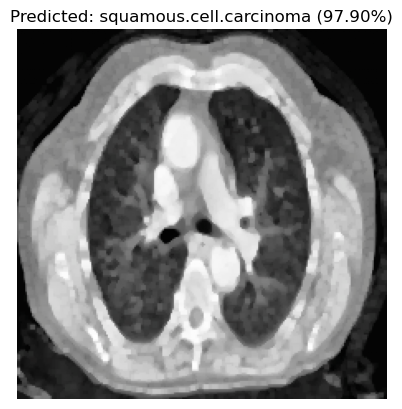

In [5]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


img_path = '/Users/unar/Downloads/SC.png' 
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  


processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)


prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]


plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 10ms/step


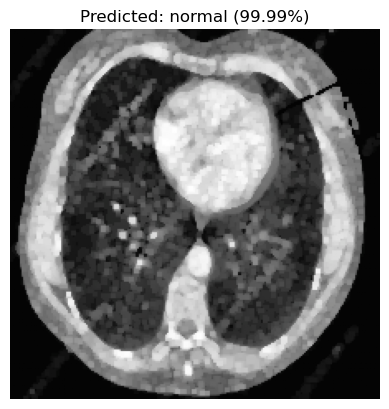

In [6]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


img_path = '/Users/unar/Downloads/NRL.png'  
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  


processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)


processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)


prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]


plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()